
BTIC Trade Data vs. Custom Basis Analysis
This notebook will:
1. Load and process BTIC trade data using `process_trade_data` from our `trade_data_processing.py` module.
2. Compute our own basis series (placeholder).
3. Compare the BTIC series to our custom basis and visualize results.

In [21]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Import the processing pipeline we defined
from trade_data_processing_polar import process_trade_data

import sys
from pathlib import Path

In [22]:
# ## 2. Load BTIC Trade Data
base_dir = Path.cwd().parent if Path.cwd().name == 'src' else Path.cwd()
btic_path = base_dir / 'data_manual' / 'PJ_Lab_EST_Trade_03_10_03_14_1min.csv'

df_btic = pl.read_csv(str(btic_path))


In [23]:
print(df_btic.head())

shape: (5, 29)
┌────────┬────────────┬────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ #RIC   ┆ Alias      ┆ Domain ┆ Date-Time  ┆ … ┆ Open Ask   ┆ High Ask   ┆ Low Ask    ┆ Close Ask │
│ ---    ┆ Underlying ┆ ---    ┆ ---        ┆   ┆ Size       ┆ Size       ┆ Size       ┆ Size      │
│ str    ┆ RIC        ┆ str    ┆ str        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│        ┆ ---        ┆        ┆            ┆   ┆ i64        ┆ i64        ┆ i64        ┆ i64       │
│        ┆ str        ┆        ┆            ┆   ┆            ┆            ┆            ┆           │
╞════════╪════════════╪════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ SETH25 ┆ null       ┆ Market ┆ 2025-03-10 ┆ … ┆ null       ┆ null       ┆ null       ┆ null      │
│        ┆            ┆ Price  ┆ T06:52:00. ┆   ┆            ┆            ┆            ┆           │
│        ┆            ┆        ┆ 000000000Z ┆   ┆            ┆            ┆ 


3. Process with Rolling VWAP + Hampel Filter

Use our standard parameters or tweak the windows/thresholds.

In [24]:
processed_btic = process_trade_data(
    df_btic,
    price_col='Last',
    volume_col='Volume',
    timestamp_col='Date-Time',
    vwap_window=5,
    filter_window=10,
    filter_threshold=3.0
)

# Show the VWAP and filtered columns
print(processed_btic.select(['Date-Time', 'vwap_5', 'vwap_5_filtered']).head())

Hampel filter replaced 105 outliers in 'vwap_5'.
shape: (5, 3)
┌─────────────────────────┬────────┬─────────────────┐
│ Date-Time               ┆ vwap_5 ┆ vwap_5_filtered │
│ ---                     ┆ ---    ┆ ---             │
│ datetime[μs, UTC]       ┆ f64    ┆ f64             │
╞═════════════════════════╪════════╪═════════════════╡
│ 2025-03-10 06:52:00 UTC ┆ null   ┆ NaN             │
│ 2025-03-10 12:08:00 UTC ┆ 6.9    ┆ 6.9             │
│ 2025-03-10 12:09:00 UTC ┆ 6.9    ┆ 6.9             │
│ 2025-03-10 12:48:00 UTC ┆ 6.9    ┆ 6.9             │
│ 2025-03-10 13:09:00 UTC ┆ 6.9    ┆ 6.9             │
└─────────────────────────┴────────┴─────────────────┘



4. Compute Custom Basis Series (Placeholder)
``

In [25]:
# TODO: Replace with actual basis calculation
basis_series = processed_btic['vwap_5_filtered'] - processed_btic['Last']
processed_btic = processed_btic.with_columns(
    basis_series.alias('custom_basis')
)
print(processed_btic.select(['Date-Time', 'custom_basis']).head())

shape: (5, 2)
┌─────────────────────────┬──────────────┐
│ Date-Time               ┆ custom_basis │
│ ---                     ┆ ---          │
│ datetime[μs, UTC]       ┆ f64          │
╞═════════════════════════╪══════════════╡
│ 2025-03-10 06:52:00 UTC ┆ null         │
│ 2025-03-10 12:08:00 UTC ┆ 0.0          │
│ 2025-03-10 12:09:00 UTC ┆ null         │
│ 2025-03-10 12:48:00 UTC ┆ null         │
│ 2025-03-10 13:09:00 UTC ┆ null         │
└─────────────────────────┴──────────────┘


5. Compare BTIC VWAP to Custom Basis


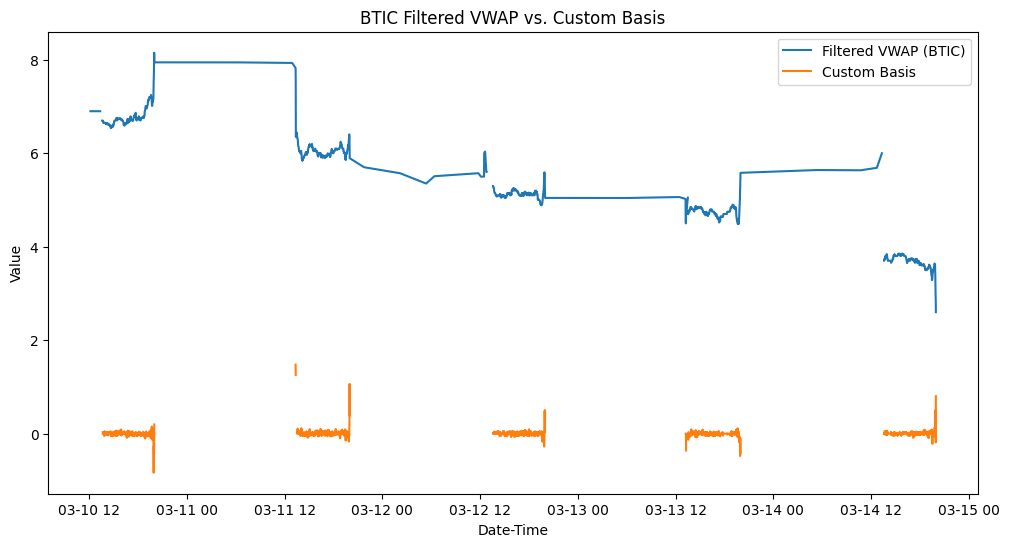

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(
    processed_btic['Date-Time'].to_numpy(),
    processed_btic['vwap_5_filtered'].to_numpy(),
    label='Filtered VWAP (BTIC)'
)
plt.plot(
    processed_btic['Date-Time'].to_numpy(),
    processed_btic['custom_basis'].to_numpy(),
    label='Custom Basis'
)
plt.xlabel('Date-Time')
plt.ylabel('Value')
plt.title('BTIC Filtered VWAP vs. Custom Basis')
plt.legend()
plt.show()

6. Compute Error Metrics

Calculate Mean Squared Error (MSE), Mean Absolute Error (MAE),
#plus standard deviations of each series and the Pearson correlation.

In [27]:
# Extract NumPy arrays
vw = processed_btic['vwap_5_filtered'].to_numpy()
basis = processed_btic['custom_basis'].to_numpy()

# 6.1 Basic error metrics
mse = np.mean((vw - basis) ** 2)
mae = np.mean(np.abs(vw - basis))

# 6.2 Standard deviations
std_vw = np.std(vw)
std_basis = np.std(basis)

# 6.3 Pearson correlation coefficient
auto_corr = np.corrcoef(vw, basis)[0, 1]

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"STD of Filtered VWAP: {std_vw:.6f}")
print(f"STD of Custom Basis: {std_basis:.6f}")
print(f"Pearson Correlation (r): {auto_corr:.4f}")

Mean Squared Error (MSE): nan
Mean Absolute Error (MAE): nan
STD of Filtered VWAP: nan
STD of Custom Basis: nan
Pearson Correlation (r): nan
